# WMHpypes Quickstart

In [1]:
from IPython.display import Image

In [2]:
import sys
sys.path.append('../')

## Grab input data

In [4]:
models_dir = '../models' # Folder containing the models as .h5  
temp_dir = './tmp' # Folder for the workflow's temporary files

In [5]:
import os
from nipype.pipeline.engine import Workflow, Node
from nipype import DataGrabber, DataSink, IdentityInterface

In [6]:
data_source = Node(interface=IdentityInterface(fields = ['weights', 'flairs']), name='data_source')
data_source.iterables = ('flairs', [os.path.join(os.getcwd(),'./test_dataset/FLAIR.nii.gz')])
data_source.inputs.weights = [os.path.join(os.getcwd(), models_dir, i) for i in os.listdir(models_dir) if i.endswith('h5')]

## Preprocessing

We perform a minimal preprocessing comprising:
1. Brain Extraction (BET)
2. Denoising (CAT12)

For a Matlab-free version of the workflow, ANTs Denoise can be used (https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.segmentation.html#denoiseimage)

In [7]:
from nipype.interfaces import cat12
from nipype.interfaces import fsl

from wmhpypes.interfaces import misc

In [8]:
bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=cat12.CAT12SANLMDenoising(), name='denoising')

220108-22:59:19,204 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


## Segmentation

In [9]:
from wmhpypes.workflows import ibbmTum_wf

test_wf = ibbmTum_wf.get_test_wf(row_st=200,
                                     cols_st=200,
                                     thres_mask=10)

Rows and Cols can be taken from the NIfTI dimension

## Output

In [10]:
out_dir =  './out' # Folder where we want to save the outputs 

In [11]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath(out_dir)
sink.inputs.regexp_substitutions = [(r'\.\.(.*)\.\.', '')]

## Connecting nodes

In [12]:
wmh_wf = Workflow(name='wmhpypes_wf', base_dir=temp_dir)
wmh_wf.connect(data_source, 'flairs', bet, 'in_file')
wmh_wf.connect(bet, 'out_file', denoising, 'in_files')
wmh_wf.connect(denoising, 'out_file', test_wf, 'inputspec.flair')
wmh_wf.connect(data_source, 'weights', test_wf, 'inputspec.weights')
wmh_wf.connect(test_wf, 'outputspec.wmh_mask', sink, '@wmh_mask')

## Plot Workflow

220108-22:59:30,997 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/example_wf.png (graph2use=colored, simple_form=True).


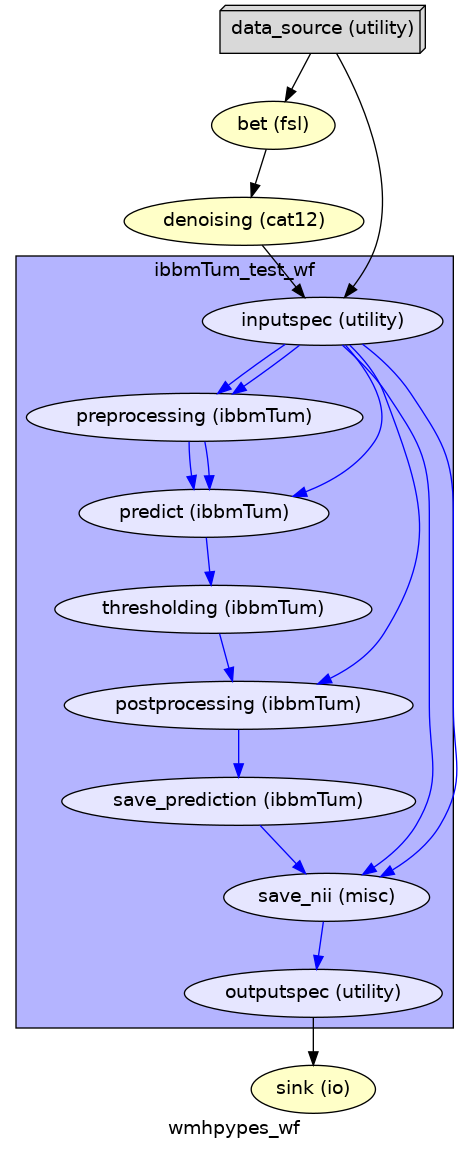

In [13]:
wmh_wf.write_graph(graph2use='colored', dotfilename='./imgs/example_wf.dot')
Image('./imgs/example_wf.png', width=300)

## Run it

In [14]:
plugin_args = {'n_procs': 5}
wmh_wf.run(plugin='MultiProc', plugin_args=plugin_args)

220108-22:59:31,20 nipype.workflow INFO:
	 Workflow wmhpypes_wf settings: ['check', 'execution', 'logging', 'monitoring']
220108-22:59:31,27 nipype.workflow INFO:
	 Running in parallel.
220108-22:59:31,28 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
220108-22:59:31,106 nipype.workflow INFO:
	 [Job 0] Cached (wmhpypes_wf.bet).
220108-22:59:33,107 nipype.workflow INFO:
	 [Job 1] Cached (wmhpypes_wf.denoising).
220108-22:59:35,105 nipype.workflow INFO:
	 [Job 2] Cached (wmhpypes_wf.ibbmTum_test_wf.preprocessing).
220108-22:59:37,151 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.ibbmTum_test_wf.predict" in "/media/orco/home_data/Dokumente/DZNE/Article202201/WMHpypes/examples/tmp/wmhpypes_wf/ibbmTum_test_wf/_flairs_..media..orco..home_data..Dokumente..DZNE..Article202201..WMHpypes..examples.....test_dataset..FLAIR.nii.gz/predict".
220108-22:59:38,297 nipype.workflow INFO:
	 [Node] Executing "predict" <wm

sizeof_hdr should be 540; set sizeof_hdr to 540


220108-23:00:23,268 nipype.workflow INFO:
	 [Node] Finished "save_nii", elapsed time 0.074458s.
220108-23:00:25,73 nipype.workflow INFO:
	 [Job 7] Completed (wmhpypes_wf.ibbmTum_test_wf.save_nii).
220108-23:00:25,75 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
220108-23:00:25,155 nipype.workflow INFO:
	 [Node] Outdated cache found for "wmhpypes_wf.sink".
220108-23:00:25,157 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.sink" in "/media/orco/home_data/Dokumente/DZNE/Article202201/WMHpypes/examples/tmp/wmhpypes_wf/_flairs_..media..orco..home_data..Dokumente..DZNE..Article202201..WMHpypes..examples.....test_dataset..FLAIR.nii.gz/sink".
220108-23:00:25,158 nipype.workflow INFO:
	 [Node] Outdated cache found for "wmhpypes_wf.sink".
220108-23:00:25,163 nipype.workflow INFO:
	 [Node] Executing "sink" <nipype.interfaces.io.DataSink>
220108-23:00:25,164 nipype.interface INFO:
	 sub: /media/orco/home_data/Dok

## Results

To plot the NIfTIs we will use NIlearn plotting capabilities

In [15]:
import nilearn.plotting as plotting

ModuleNotFoundError: No module named 'nilearn'

#### Input file

In [ ]:
flair = './test_dataset/FLAIR.nii.gz'
out = './out/_flairs_test_flair.nii.gz/prediction.nii.gz'

In [ ]:
plotting.plot_anat(flair)

#### Result

In [ ]:
plotting.plot_roi(out, flair) #, display_mode='mosaic' )

In [ ]:
plotting.plot_anat(out)